In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# NLP 文档分类 IMDB

In [2]:
from fastai.text import *

1. **语言模型：预测下一个单词是什么** 
2. **当使用语言模型时，将训练和测试集连接在一起，然后只拆分一个较小的验证集这样就可以获得更多数据来训练您的语言模型**
3. **语言模型有自己的标签。 文本本身就是标签，因此语言模型（label_for_lm）的可以生成标签**

## 数据准备

In [3]:
root = untar_data(URLs.IMDB_SAMPLE)
root
root.ls()

PosixPath('/home/lyc/.fastai/data/imdb_sample')

[PosixPath('/home/lyc/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/home/lyc/.fastai/data/imdb_sample/texts.csv')]

- 查看数据
- 标签指示文本是正面评价还是反面评价
- is_valid 表示是否是验证集

In [4]:
df = pd.read_csv(root/'texts.csv')
df.head()
df.tail()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


,label,text,is_valid
995,negative,There are many different versions of this one ...,True
996,positive,Once upon a time Hollywood produced live-actio...,True
997,negative,Wenders was great with Million $ Hotel.I don't...,True
998,negative,Although a film with Bruce Willis is always wo...,True
999,positive,"A compelling, honest, daring, and unforgettabl...",True


In [5]:
df.text[0]  # negative

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

## 创建数据束

In [6]:
# data = TextDataBunch.from_csv(root, 'texts.csv', text_cols=1, label_cols=0)

In [7]:
# data.train_ds[0]

1. 图像数据和文本数据都是 **非结构化数据**
2. 图像数据本身就是整型或者浮点型，可以直接使用，但是文本数据不可以直接使用，必须要先转化为数字形式
3. tokenization and numericalization（TextDataBunch） 分词-数值化

- 为论文避免再次计算，我们可以保存预处理后的数据束

In [8]:
# data.save()  # 保存数据

- 重新加载数据束

In [9]:
data = load_data(root)

### Tokenization

- 这个步骤即：把文本分割成单词即 token，最简单的方式是按照空格进行分割（英文）
    - 需要注意标点
    - 特殊的符号处理
    - 词的处理，如 isn't

In [10]:
doc(TextClasDataBunch)

class TextClasDataBunch [source] [test] TextClasDataBunch ( train_dl : DataLoader , valid_dl : DataLoader , fix_dl : DataLoader = None , test_dl : Optional [ DataLoader ]= None , device : device = None , dl_tfms : Optional [ Collection [ Callable ]]= None , path : PathOrStr = '.' , collate_fn : Callable = 'data_collate' , no_check : bool = False ) :: TextDataBunch 
 
 × No tests found for TextClasDataBunch . To contribute a test please refer to this guide and this discussion . Create a TextDataBunch suitable for training an RNN classifier. 
 Show in docs

In [11]:
data = TextClasDataBunch.from_csv(root, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


- ‘s 是一个词 it’s
- didn't 被分为 did n't
- HTML 符号被删除
- xx 开头的表示不确定的词
- 所有的词都 小写

### Numericalization

- 一旦我们从文本中提取了标记，我们就会通过创建所有单词的列表来转换为整数。
- 我们**只保留至少出现两次且最大词汇量为60,000（默认情况下）**
- 替换未知词 `UNK`

- ids 和 tokens 的对应关系被存放在 data.vocab.itos ,(int 2 string)

In [12]:
data.vocab.itos[5:15]

['xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', ',', '.', 'and', 'a', 'of']

In [13]:
x, y = data.train_ds[0]
y

Category positive

In [14]:
x

Text xxbos xxmaj this review contains spoilers for those who are not aware of the details of the true story on which this movie is based . 
 
  xxmaj the right to be presumed " xxmaj innocent until xxunk guilty " is a basic xxunk of anyone in a xxunk society ; but according to xxmaj fred xxmaj xxunk 's xxunk but sadly convincing story of a famous xxmaj australian murder trial , it was not granted to xxmaj lindy xxmaj chamberlain , xxunk of killing her baby . xxmaj the story suggesting her innocence was unlikely ( a xxunk was alleged to have taken it ) , but those xxunk her guilt even more so , and there was no solid evidence against her . xxmaj but the xxmaj australian public was transfixed by the possibility of her guilt , and the deeply religious xxmaj xxunk appeared creepy when appearing in the media ( and the media themselves , of course , were anything but innocent in this process ) . xxmaj so although xxunk by an initial xxunk , they were later xxunk and convicted . xxmaj althoug

In [15]:
# 语言模型通常会占用比较多的内存资源
data = (TextList.from_csv(root, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(bs=32))

In [16]:
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


## 构建模型

- 使用完整的数据集

In [17]:
root = untar_data(URLs.IMDB)
root.ls()

[PosixPath('/home/lyc/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/lyc/.fastai/data/imdb/train'),
 PosixPath('/home/lyc/.fastai/data/imdb/test'),
 PosixPath('/home/lyc/.fastai/data/imdb/README'),
 PosixPath('/home/lyc/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/lyc/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/lyc/.fastai/data/imdb/unsup'),
 PosixPath('/home/lyc/.fastai/data/imdb/models'),
 PosixPath('/home/lyc/.fastai/data/imdb/imdb.vocab')]

- unsup 表示没有标注的数据
- 使用预训练模型[wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)，这个预训练是用来预测下一个词是什么,所以对于 imdb 数据集我们作同样的操作
- 只在训练集作 打乱操作，验证集不做打乱

In [18]:
bs = 32

- filter_by_folder 使用 from_folder 会导致该路径下的所有文件夹被包含进来，但是也有可能这个路径下包含别的文件夹，所以使用 filter_by_folder 进行制定文件夹

In [19]:
# data_lm = (TextList.from_folder(root)
#             .filter_by_folder(include=['train', 'test', 'unsup']) 
#             .split_by_rand_pct(0.1)
#             .label_for_lm()           
#             .databunch(bs=bs))

In [20]:
# data_lm.save('data_lm.pkl')

In [21]:
data_lm = load_data(root, 'data_lm.pkl', bs=bs)

In [22]:
data_lm.show_batch()

idx,text
0,"for its story . xxbos xxmaj also known as "" xxmaj stairway to xxmaj heaven "" in the xxup us . xxmaj during xxup wwii xxmaj british xxmaj peter xxmaj carter 's ( xxmaj david xxmaj niven ) plane is shot down in combat but he survives . xxmaj he meets and falls in love with lovely xxmaj june ( xxmaj kim xxmaj hunter ) . xxmaj but it seems"
1,"david trying to get her back . \n \n xxmaj michael xxmaj caine is a brilliant actor , of course , and plays a character who is very determined and prepared to do anything to get his wife back , but rather hopeless with a gun and action stuff . xxmaj he 's helped out first by a xxmaj englishman campaigning against the slave trade that no one acknowledges"
2,\n \n xxmaj if i had a time machine i would go back to 1972 and say goodbye to the 21st century cesspool we have now . xxbos i was given the opportunity to see this 1926 film in a magnificently restored theater that was once part of the extensive xxmaj paramount chain of vaudeville houses . xxmaj this xxmaj paramount has a xxunk xxmaj wurlitzer ' organ 
3,"or "" xxmaj hollywood "" about this set - in - xxmaj california film . xxmaj it is truly a slice of life . xxmaj the modest house in which xxmaj sandra lives at the beginning of the film , the simple dresses worn by the character , the scene where xxmaj sandra wakes up in the morning to find xxmaj uschi xxmaj digart bouncing at her front door ,"
4,". xxmaj if you are feeling sick at heart , pop it in- it 'll warm you up and make you hum xxmaj mmm xxmaj mmm xxmaj good ! \n \n xxmaj quote of the film : \n \n xxunk ! xxmaj surprise ! xxunk duh xxunk xxmaj happy xxmaj birthday ! xxbos "" xxmaj it 's all up to you , xxmaj ed ? "" "" xxmaj"


## 模型

In [23]:
arch = AWD_LSTM

In [24]:
learn = language_model_learner(data_lm, arch, drop_mult=0.3)

- 学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


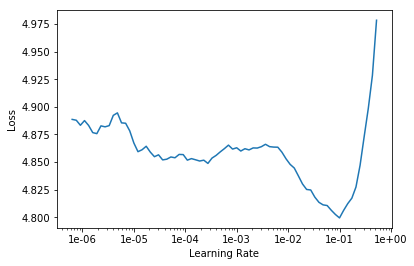

In [25]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

- 训练模型

In [26]:
lr1 = 1e-2

- 时间特别长

In [27]:
learn.fit_one_cycle(5, lr1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.336946,4.229248,0.279055,34:03
1,4.442832,4.306439,0.272879,34:02
2,4.372556,4.238265,0.278638,34:03
3,4.289885,4.147606,0.287455,34:02
4,4.229659,4.121236,0.290689,35:21


In [28]:
learn.save('stage1')

In [41]:
# learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [25]:
learn.load('stage1');

- 模型结构

In [26]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60004, bias=True)
    (output_dp): RNNDropout()
  )
)

- stage 2

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


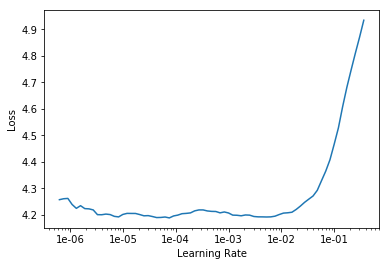

In [30]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [31]:
lr2 = 3e-3

- 贫民党伤不起，跑不动 就跑一个 epoch  主要是为了微调 编码器 的参数
- 循环网络是真的慢
- 训练号一个阶段后就重新启动，重新加载保存的模型

In [32]:
learn.fit_one_cycle(1, slice(3e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.954099,3.893692,0.314265,47:36


In [33]:
learn.save('stage2')

In [35]:
learn.load('stage2');

/home/lyc/miniconda3/envs/torch36/lib/python3.6/site-packages/fastai/basic_train.py:324: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


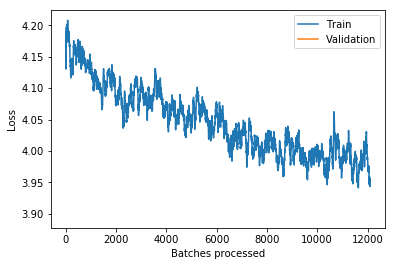

In [36]:
learn.recorder.plot_losses()

- 预测

In [38]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 5

In [40]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was so good . i love the people who saw this film at the Film Festival . The movie did n't have the usual Hollywood style and had a good idea . But it
I liked this movie because i loved it once . i have not seen it in any school since i went to school . i was glad i did n't . The acting is great , and i believe that the acting was good
I liked this movie because its a great story and it was cute and fun . It was believable and funny and had a nice ending . i was kinda disappointed . The film i saw was so badly made , it was
I liked this movie because it was a bad horror movie because everything looked completely stupid . The acting was awful , there was nothing new to i , and it was horribly boring . The director did a great job with the
I liked this movie because it did n't have the attention of the better . But is it for me ? It is , really , very good , and it has some good humor and a good script that i like .


- 保存编码器

In [49]:
learn.save_encoder('fine_tuned_enc')

但是，我们的任务是分类而不是预测下一个单词是什么

## 分类

- 我们再次创建一个数据集，只包含有标签的那部分数据

In [3]:
bs = 32
path = untar_data(URLs.IMDB)

- 这里必须传入语言模型的词典，否则上述的语言模型就算无意义的

In [51]:
# data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
#              .split_by_folder(valid='test')
#              .label_from_folder(classes=['neg', 'pos'])
#              .databunch(bs=bs))

In [52]:
# data_clas.save('data_clas.pkl')

In [4]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [54]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * * xxmaj attention xxmaj spoilers * * \n \n xxmaj first of all , let me say that xxmaj rob xxmaj roy is one of the best films of the 90 's . xxmaj it was an amazing achievement for all those involved , especially the acting of xxmaj liam xxmaj neeson , xxmaj jessica xxmaj lange , xxmaj john xxmaj hurt , xxmaj brian xxmaj cox",pos
"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n \n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this",pos
"xxbos xxmaj warning : xxmaj spoilers xxmaj galore ! \n \n xxmaj tim xxmaj burton remaking this sui generis movie is about as sensible as remaking xxmaj psycho - oh , that 's right , some idiot already did that - i rest my case . \n \n xxmaj movie opens with xxunk blundering a simulation , proving he 's not that smart from the outset . xxmaj",neg
"xxbos xxmaj anyone who visited drive - ins in the 1950s , 60s , and 70s , must have seen a film or two by xxmaj american xxmaj international xxmaj pictures , a distributor that resembled 1980s giant xxmaj cannon xxmaj films . xxmaj wherever movie - goers ventured , xxup aip would be right there to supply the latest en vogue titles - in the 50s came horror movies",neg


- 我们使用之前训练好的 **编码器** 进行分类
- drop_mult 正则化

In [5]:
arch = AWD_LSTM
learn = text_classifier_learner(data_clas, arch, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [56]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60004, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(60004, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=

- 这里我们仍然使用之前的编码器，将之前的解码器部分更改成，我们这里的分类部分 (1)

In [60]:
learn.model[0]  # 编码器部分 这部分的参数已经训练好

MultiBatchEncoder(
  (module): AWD_LSTM(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
)

In [61]:
learn.model[1]  # 分类器部分

PoolingLinearClassifier(
  (layers): Sequential(
    (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=1200, out_features=50, bias=True)
    (3): ReLU(inplace)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.1)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

- 学习率调整

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


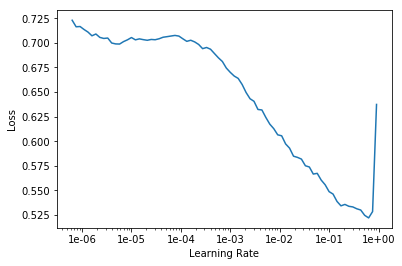

In [62]:
learn.lr_find()
learn.recorder.plot()

- 训练分类器

In [63]:
lr3 = 1e-1

In [66]:
learn.fit_one_cycle(3, slice(lr3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.422958,0.352917,0.844240,06:12
1,0.373596,0.318603,0.871360,06:03
2,0.363797,0.263551,0.895360,05:53


In [67]:
learn.save('first')

In [6]:
learn.load('first');

- 查看那些参数或者layer可以训练

In [7]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [61, 400]            0          False     
______________________________________________________________________
RNNDropout           [61, 1150]           0          False     
______________________________________________________________________
RNNDropout           [61, 1150]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
______________________________________________________________

- 微调编码器参数

In [8]:
learn.freeze_to(-2)
# 除了最后的两个 layers_group 其余的都不可训练

- 查看那些参数或者layer可以训练

In [9]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [61, 400]            0          False     
______________________________________________________________________
RNNDropout           [61, 1150]           0          False     
______________________________________________________________________
RNNDropout           [61, 1150]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
______________________________________________________________

In [10]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.273254,0.229680,0.914240,06:47


In [11]:
learn.save('second')

In [6]:
learn.load('second');

In [16]:
g = learn.layer_groups
len(g)
g

5

[Sequential(
   (0): Embedding(60004, 400, padding_idx=1)
   (1): EmbeddingDropout(
     (emb): Embedding(60004, 400, padding_idx=1)
   )
 ), Sequential(
   (0): WeightDropout(
     (module): LSTM(400, 1150, batch_first=True)
   )
   (1): RNNDropout()
 ), Sequential(
   (0): WeightDropout(
     (module): LSTM(1150, 1150, batch_first=True)
   )
   (1): RNNDropout()
 ), Sequential(
   (0): WeightDropout(
     (module): LSTM(1150, 400, batch_first=True)
   )
   (1): RNNDropout()
 ), Sequential(
   (0): PoolingLinearClassifier(
     (layers): Sequential(
       (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (1): Dropout(p=0.2)
       (2): Linear(in_features=1200, out_features=50, bias=True)
       (3): ReLU(inplace)
       (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (5): Dropout(p=0.1)
       (6): Linear(in_features=50, out_features=2, bias=True)
     )
   )
 )]

- 显卡撑不住，后面的不训练了

In [9]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([5.8153e-04, 9.9942e-01]))

In [13]:
learn.predict("The movie was bad!")

(Category neg, tensor(0), tensor([0.9765, 0.0235]))

- 上述分类

1. unfreeze the last two layers
1. train it a little bit more
1. unfreeze the next layer again
1. train it a little bit more
1. unfreeze the whole thing
1. train it a little bit more

- 一层一层的训练往往是更有效的（这里由于显存不足，所以不做训练）
- 循环网络应当使用更小的动量